In [1]:
'''This script demonstrates VAE on image data

 #Reference
 - Jointly Trained Variational Autoencoder for Multi-Modal Sensor Fusion https://ieeexplore.ieee.org/document/9011314
 - rubiks-dataset https://github.com/tik0/rubiks-dataset
'''

import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from scipy.stats import norm
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape, Layer, Dropout
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
import tensorflow.keras as keras
import vae_tools.loader as loader

import vae_tools
from vae_tools import plot_model, layers, nb_tools, viz, loader, build_model, sanity, sampling, custom_variational_layer

Using TensorFlow backend.


Configure and load the data

In [ ]:
epochs = 100           # Training steps 
target_size = (30, 40) # Image size

# Load the data
action_train, v1_train, v2_train = loader.rubiks(num_tuples = int(5000), target_size = (30, 40), working_dir = '/tmp')

Configure and build the MMVAE

In [ ]:
# Define the MMVA

# input image dimensions and config
use_conv = False
batch_size = 128
action_dim = 3
image_rows_cols_chns = (target_size[0], target_size[1], 3)
original_dim = np.prod(image_rows_cols_chns)
latent_dim = 2
intermediate_dim = 256 # former 128
intermediate_dim_2 = int(intermediate_dim / 2)
save_model = False
#beta = 0.012207031 # 50.
beta = 1.

X_train_s1 = v1_train
X_train_s2 = v2_train
X_train_actions = action_train

if use_conv:
    # number of convolutional filters to use
    filters = 32 # former 64
    # convolution kernel size
    num_conv = 3
    # Other values
    rows = image_rows_cols_chns[0]
    rows_2 = int(rows/2)
    cols = image_rows_cols_chns[1]
    cols_2 = int(cols/2)
    img_chns = image_rows_cols_chns[2]
    if keras.backend.image_data_format() == 'channels_first':
        original_img_size = (image_rows_cols_chns[2], image_rows_cols_chns[0], image_rows_cols_chns[1])
        output_shape_reshape = (batch_size, filters, rows_2, cols_2)
        output_shape_upsamp = (batch_size, filters, rows+1, cols+1)
    else:
        original_img_size = image_rows_cols_chns
        output_shape_reshape = (batch_size, rows_2, cols_2, filters)
        output_shape_upsamp = (batch_size, rows+1, cols+1, filters)
else:
    # Reshape the data
    # X_train = X_train.reshape(len(X_train),np.prod(X_train.shape[1:]))
    X_train_s1_flatten = X_train_s1.reshape((X_train_s1.shape[0], np.prod(X_train_s1.shape[1:])))
    X_train_s2_flatten = X_train_s2.reshape((X_train_s2.shape[0], np.prod(X_train_s2.shape[1:])))

if use_conv:
    encoder = [[
        Input(shape=original_img_size),
        Conv2D(img_chns, kernel_size=(2, 2), padding='same', activation='relu'),
        Conv2D(filters, kernel_size=(2, 2), padding='same', activation='relu', strides=(2, 2)),
        Conv2D(filters, kernel_size=num_conv, padding='same', activation='relu', strides=1),
        Conv2D(filters, kernel_size=num_conv, padding='same', activation='relu', strides=1),
        Flatten(),
        Dense(intermediate_dim, activation='relu')
    ]]
    
    decoder = [[
        Dense(intermediate_dim, activation='relu'),
        Dense(filters * rows_2 * cols_2, activation='relu'),
        Reshape(output_shape_reshape[1:]),
        Conv2DTranspose(filters, kernel_size=num_conv, padding='same', strides=1, activation='relu'),
        Conv2DTranspose(filters, kernel_size=num_conv, padding='same', strides=1, activation='relu'),
        Conv2DTranspose(filters, kernel_size=(3, 3), strides=(2, 2), padding='valid', activation='relu'),
        Conv2D(img_chns, kernel_size=2, padding='valid', activation='sigmoid')
    ]]

else:
    e1_1 = Input(shape=(original_dim + action_dim,))
    e1_2 = Input(shape=(original_dim,))
    e2_1 = Dense(intermediate_dim, activation='relu')
    e2_2 = Dense(intermediate_dim, activation='relu')
    e3_1 = Dense(intermediate_dim_2, activation='relu')
    e3_2 = Dense(intermediate_dim_2, activation='relu')
    encoder = [[e1_1, e2_1, e3_1], [e1_2, e2_2, e3_2]]
    d1_1 = Dense(intermediate_dim_2, activation='relu')
    d2_1 = Dense(intermediate_dim, activation='relu')
    d3_1 = Dense(original_dim + action_dim, activation='sigmoid')
    d1_2 = Dense(intermediate_dim_2, activation='relu')
    d2_2 = Dense(intermediate_dim, activation='relu')
    d3_2 = Dense(original_dim, activation='sigmoid')
    decoder = [[d1_1, d2_1, d3_1], [d1_2, d2_2, d3_2]]

latent_encoder = Dense(intermediate_dim, activation='relu', name="lat_enc")
latent_encoder.is_relative = [False]
latent_encoder.layer_dimensions = [intermediate_dim]
latent_encoder.activations = ['relu']
model_obj = vae_tools.mmvae.MmVae(latent_dim, encoder, decoder, [original_dim + action_dim, original_dim],
                                  beta, beta_is_normalized = False, reconstruction_loss_metrics = [vae_tools.mmvae.ReconstructionLoss.MSE],
                                  latent_encoder = latent_encoder,
                                  name='Vae')
vae = model_obj.get_model()
vae.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss=None)
#vae_tools.viz.plot_model(vae, file = 'myVAE', print_svg = False, verbose = True)

In [7]:
#X_train_s1_flatten.shape
#X_train_actions.shape
#np.concatenate((X_train_s1_flatten,X_train_actions), axis=1).shape
X_train_s1_flatten = np.concatenate((X_train_s1_flatten,X_train_actions), axis = 1)

In [8]:
# Train
#vae.fit([X_train_s1_flatten, X_train_s2_flatten],
#        shuffle=True,
#        epochs=epochs,
#        batch_size=batch_size,
#        verbose = 1)

vae.fit([X_train_s1_flatten, X_train_s2_flatten],
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        verbose = 1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
5000/5000 [==============================] - 8s 2ms/step - loss: 755.0764
Epoch 2/100
5000/5000 [==============================] - 6s 1ms/step - loss: 591.9713
Epoch 3/100
5000/5000 [==============================] - 6s 1ms/step - loss: 455.6237
Epoch 4/100
5000/5000 [==============================] - 6s 1ms/step - loss: 341.2376
Epoch 5/100
5000/5000 [==============================] - 6s 1ms/step - loss: 277.7994
Epoch 6/100
5000/5000 [==============================] - 6s 1ms/step - loss: 235.1256
Epoch 7/100
5000/5000 [==============================] - 6s 1ms/step - loss: 227.0782
Epoch 8/100
5000/5000 [==============================] - 6s 1ms/step - loss: 225.1961
Epoch 9/100
5000/5000 [==============================] - 6s 1ms/step - loss: 224.2542
Epoch 10/100
5000/5000 [==============================] - 6s 1ms/step - loss: 223.2145
Epoch 11/100
5000/5000 [==============================] - 6s 1ms/step - loss: 220.9633
Epoc

5000/5000 [==============================] - 6s 1ms/step - loss: 125.4833
Epoch 93/100
5000/5000 [==============================] - 6s 1ms/step - loss: 124.2819
Epoch 94/100
5000/5000 [==============================] - 6s 1ms/step - loss: 125.7009
Epoch 95/100
5000/5000 [==============================] - 6s 1ms/step - loss: 128.2441
Epoch 96/100
5000/5000 [==============================] - 6s 1ms/step - loss: 136.4765
Epoch 97/100
5000/5000 [==============================] - 6s 1ms/step - loss: 124.4603
Epoch 98/100
5000/5000 [==============================] - 6s 1ms/step - loss: 125.1538
Epoch 99/100
5000/5000 [==============================] - 6s 1ms/step - loss: 126.3102
Epoch 100/100
5000/5000 [==============================] - 6s 1ms/step - loss: 121.9344


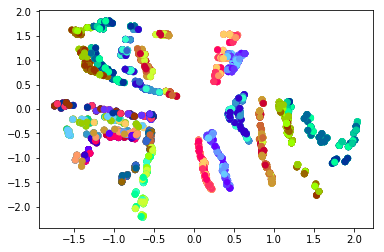

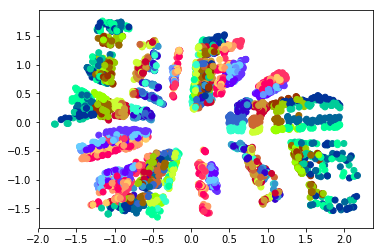

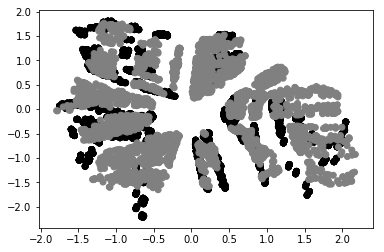

In [9]:
# Check the output distribution of the feature extractor
c_cube_states = []
for left, front, right in zip(cube_states['left'], cube_states['front'], cube_states['right']):
    c_cube_states.append([cube_colors.index(left), cube_colors.index(front), cube_colors.index(right)])
c_cube_states = np.asarray(c_cube_states)/np.max(c_cube_states)
#X_train_flatten = X_train.reshape((X_train.shape[0], np.prod(X_train.shape[1:])))

X_train_feat_uni = model_obj.get_encoder_mean([encoder[0][0]]).predict(X_train_s1_flatten)
plt.scatter(X_train_feat_uni[:,0], X_train_feat_uni[:,1], c=c_cube_states)
plt.show()

X_train_feat_bi = model_obj.get_encoder_mean([encoder[0][0], encoder[1][0]]).predict([X_train_s1_flatten, X_train_s2_flatten])
plt.scatter(X_train_feat_bi[:,0], X_train_feat_bi[:,1], c=c_cube_states)
plt.show()

plt.scatter(X_train_feat_uni[:,0], X_train_feat_uni[:,1], c=np.tile(np.asarray([0.,0.,0.]), (X_train_feat_uni.shape[0],1)))
plt.scatter(X_train_feat_bi[:,0], X_train_feat_bi[:,1], c=np.tile(np.asarray([.5,.5,.5]), (X_train_feat_bi.shape[0],1)))
plt.show()


[0.5 1.  0. ]
[1.1345835  0.02523719]


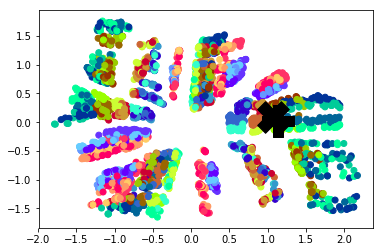

In [62]:
idx = 14 # left/right => We should stay at least in the same cluster, because the VAE should predict the other view
idx = 0 # front/right => Switch cluster, because the VAE can not predict the right from front view
idx = 1 # front/left => Switch cluster, because the VAE can not predict the left from front view
idx = 3 # right/left => We should stay at least in the same cluster, because the VAE should predict the other view
idx = 5 # right/front => Switch cluster, because the VAE can not predict the front from right view
idx = 6 # left/front => Switch cluster, because the VAE can not predict the front from left view
print(action_train[idx])
print(X_train_feat_bi[idx])

#X_train_feat_uni_1 = model_obj.get_encoder_mean([encoder[0][0]]).predict(X_train_s1_flatten)
#X_train_feat_uni = model_obj.get_encoder_mean([encoder[0][0]]).predict(X_train_s1_flatten)
#X_train_feat_bi = model_obj.get_encoder_mean([encoder[0][0], encoder[1][0]]).predict([X_train_s1_flatten, X_train_s2_flatten])

plt.scatter(X_train_feat_bi[:,0], X_train_feat_bi[:,1], c=c_cube_states)
plt.scatter(X_train_feat_uni_1[idx,0], X_train_feat_uni_1[idx,1], c=[.0,.0,.0], s=1000, marker='X',linewidths=1)
plt.scatter(X_train_feat_bi[idx,0], X_train_feat_bi[idx,1], c=[.0,.0,.0], s=1000, marker='P',linewidths=1)
#plt.xlim([-.5, -.3])
#plt.ylim([-.1, .1])
plt.show()

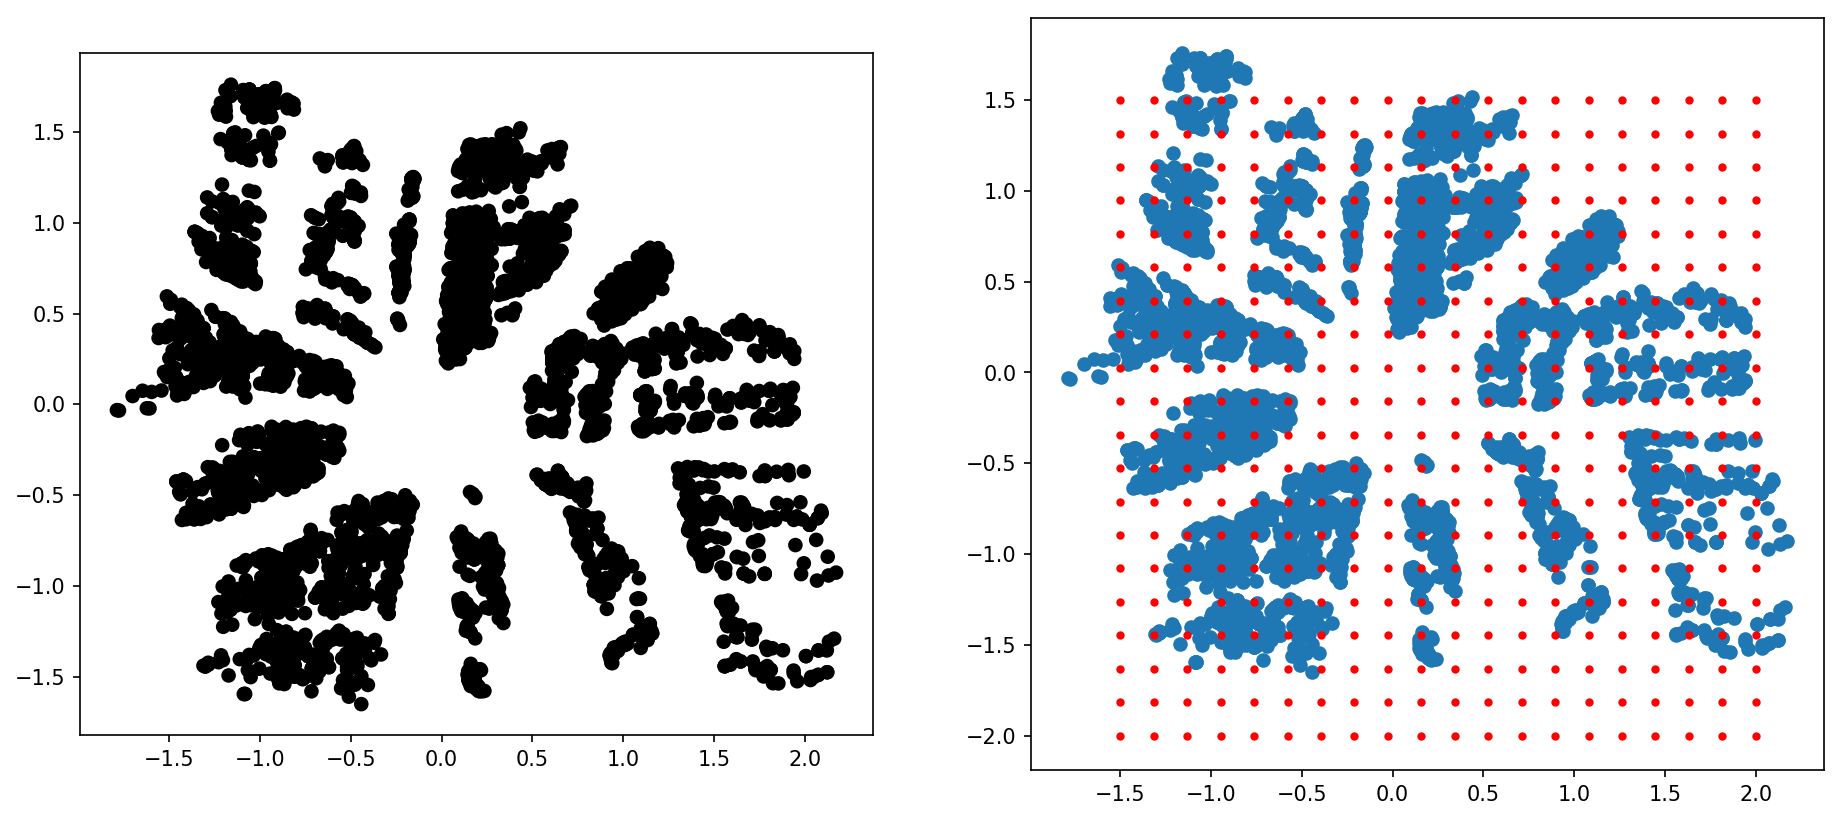

/opt/repositories/twbserver_notebook/notebook/tools/vae_tools/viz.py:132: UserWarning: Output of decoder is not reshapable into size image_rows_cols_chns (num_val_image=3600 != num_val_decoder=3603). Will truncate values.
  warnings.warn("Output of decoder is not reshapable into size image_rows_cols_chns (num_val_image=" + str(num_val_image) + " != num_val_decoder=" + str(num_val_decoder) + "). Will truncate values.")


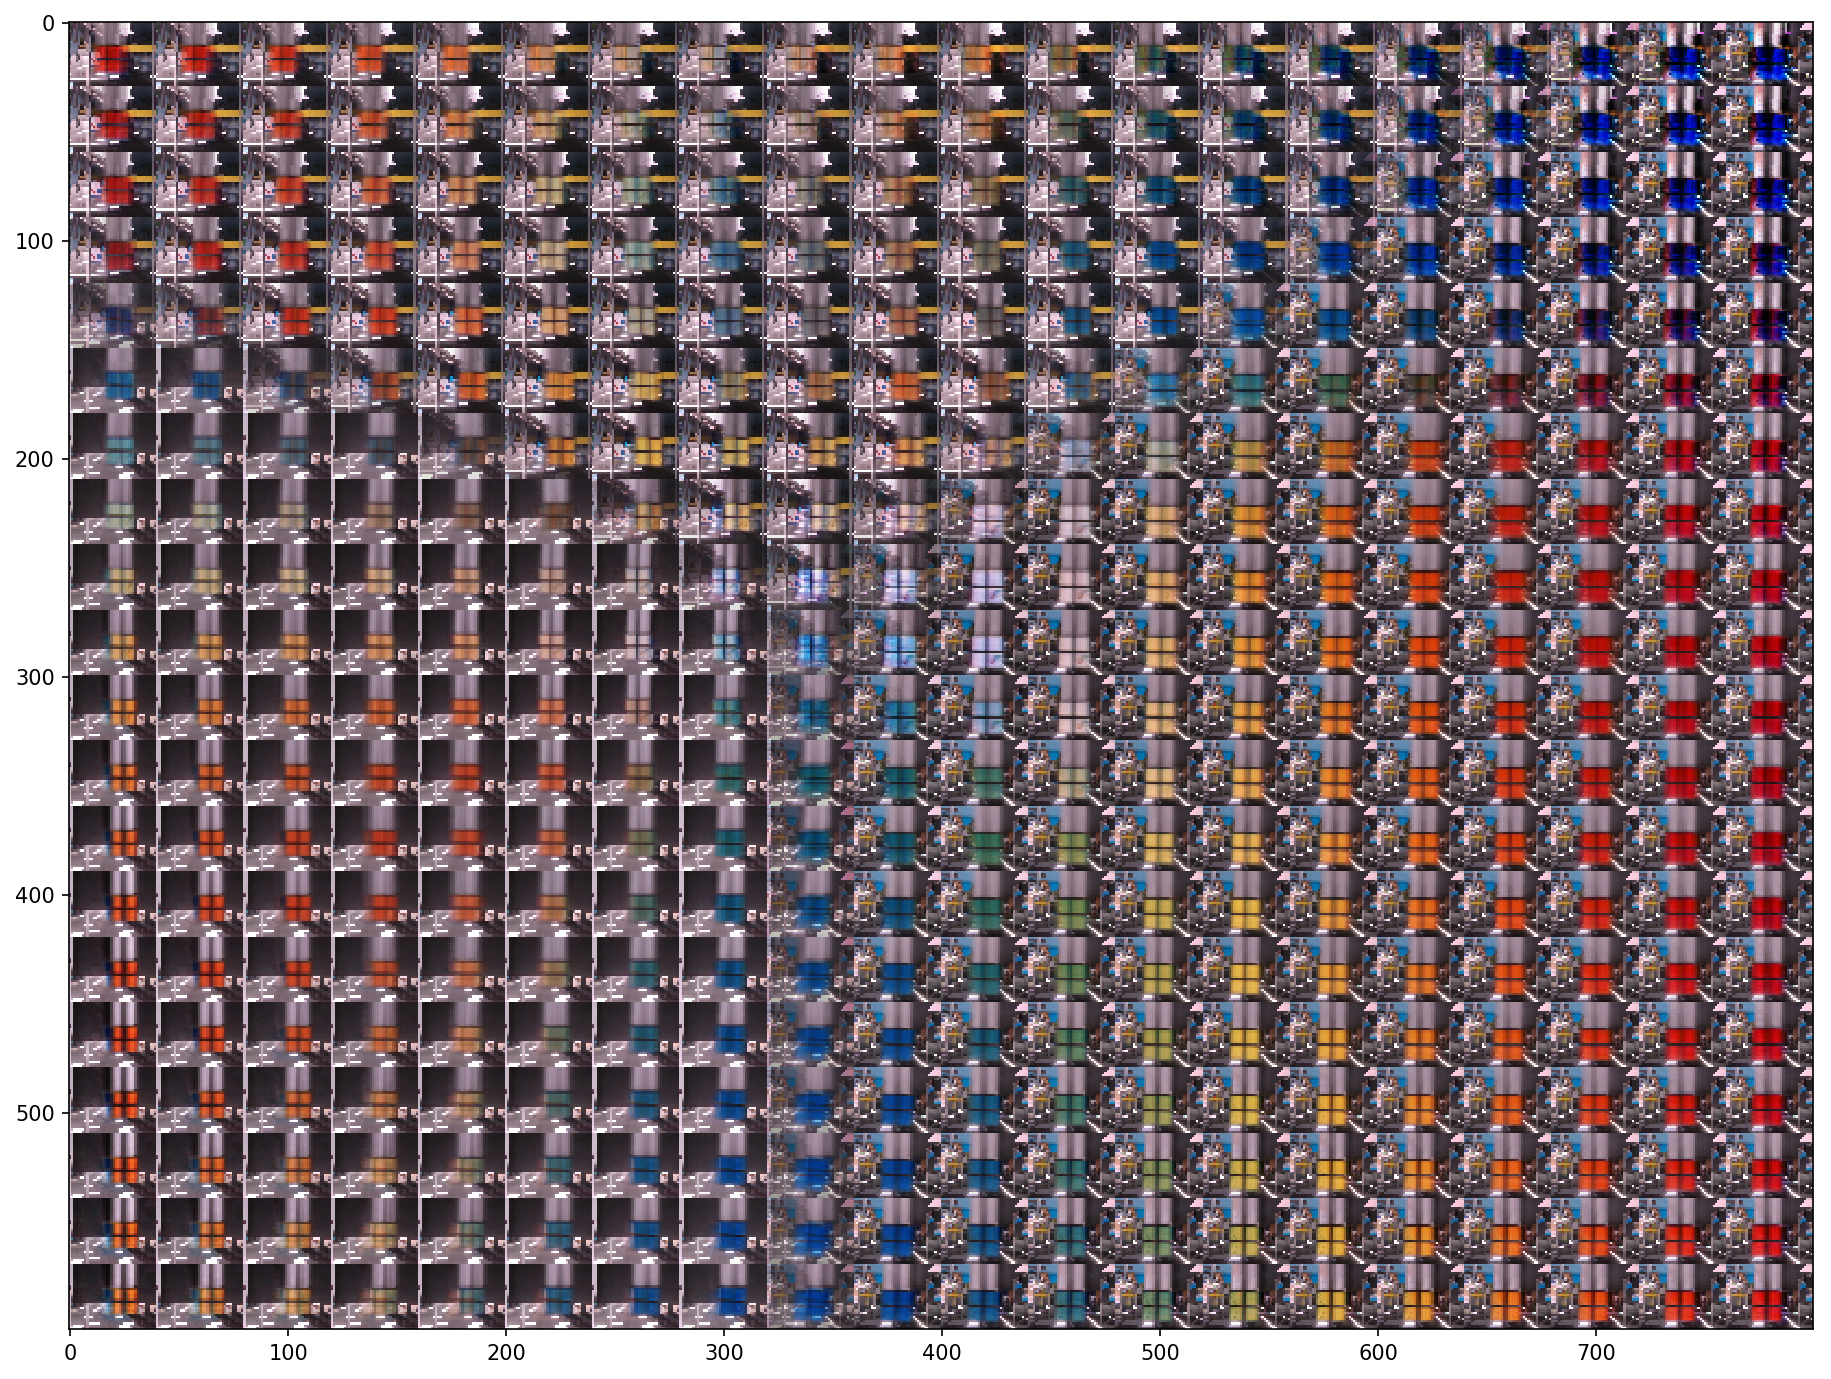

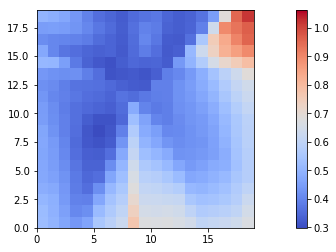

In [11]:
import vae_tools
from importlib import reload
reload(vae_tools)

# Vizualization
# Encode samples to get the min and max values in latent space
#x_test_encoded = model_obj.get_encoder_mean([encoder[0][0]]).predict(X_train, batch_size=batch_size)

# display a 2D manifold
nx = 20
ny = 20

## linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
## to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.1, 0.9, nx))
grid_y = norm.ppf(np.linspace(0.1, 0.9, ny))
grid_x = np.linspace(-1.5, 2., nx)
grid_y = np.linspace(-2., 1.5, ny)
#grid_x = np.linspace(np.amin(x_test_encoded[:, 0]), np.amax(x_test_encoded[:, 0]), nx)
#grid_y = np.linspace(np.amin(x_test_encoded[:, 1]), np.amax(x_test_encoded[:, 1]), ny)

# display a 2D plot of the digit classes in the latent space
import vae_tools
from importlib import reload  # Python 3.4+ only.
viz = reload(vae_tools.viz)
#vae_tools.viz.scatter_encoder([X_train_s1_flatten, X_train_s2_flatten], np.zeros((len(X_train_s1_flatten),3)), grid_x, grid_y, model_obj, figsize=(15, 15), dpi=150)
vae_tools.viz.scatter_encoder_2([X_train_s1_flatten, X_train_s2_flatten],
                  np.zeros((len(X_train_s1_flatten),3)),
                  grid_x, grid_y,
                  model_obj.get_encoder_mean([encoder[0][0], encoder[1][0]]),
                  figsize=(15, 15), dpi=150)
#vae_tools.viz.scatter_encoder(X_train, np.zeros((len(X_train),3)), grid_x, grid_y, model_obj, figsize=(15, 15), dpi=150)

# Plot the resampled inputs
#figure, x_mean_test_encoded, x_std_test_encoded = viz.get_image_dec_enc_samples(grid_x, grid_y, model_obj, image_rows_cols_chns)
#figure, x_mean_test_encoded, x_std_test_encoded = viz.get_image_dec_enc_samples_2(grid_x, grid_y, encoder_mean, encoder_log_var, decoder, 2, image_rows_cols_chns)
encoder_mean = model_obj.get_encoder_mean([encoder[0][0]])
encoder_log_var = model_obj.get_encoder_logvar([encoder[0][0]])
decoder_model = model_obj.get_decoder(decoder_output_list = [decoder[0][-1]])
figure, z_reencoded_mean, z_reencoded_std = viz.get_image_dec_enc_samples_2(grid_x, grid_y, encoder_mean, encoder_log_var, decoder_model, 2, image_rows_cols_chns)
plt.figure(figsize=(15, 15), dpi=150)
plt.imshow(figure, cmap='Greys_r')
plt.show()

# Plot the resampled std deviations
X, Y = np.meshgrid(np.arange(0,len(grid_x)), np.arange(0,len(grid_y)))
plt.pcolor(X, Y, z_reencoded_std, cmap='coolwarm', vmin=z_reencoded_std.min(), vmax=z_reencoded_std.max())
plt.colorbar()
plt.axis("image")
plt.show()

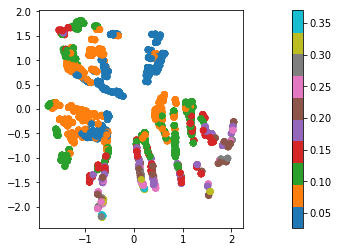

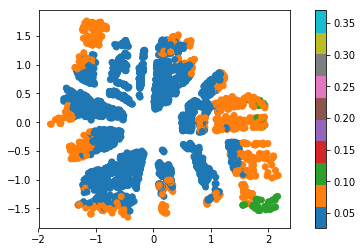

In [64]:
# Plot the resampled std deviations
#X, Y = np.meshgrid(np.arange(0,len(grid_x)), np.arange(0,len(grid_y)))
x_encoded_mean_uni = model_obj.get_encoder_mean([encoder[0][0]]).predict(X_train_s1_flatten)
x_encoded_logvar_uni = model_obj.get_encoder_logvar([encoder[0][0]]).predict(X_train_s1_flatten)
x_encoded_mean_bi = model_obj.get_encoder_mean([encoder[0][0], encoder[1][0]]).predict([X_train_s1_flatten, X_train_s2_flatten])
x_encoded_logvar_bi = model_obj.get_encoder_logvar([encoder[0][0], encoder[1][0]]).predict([X_train_s1_flatten, X_train_s2_flatten])

# Uni
x_encoded_logvar_viz_uni = np.sum(np.exp(x_encoded_logvar_uni), axis = 1)
val_min = np.concatenate((x_encoded_logvar_viz_uni, x_encoded_logvar_viz_bi), axis = 0).min()
val_max = np.concatenate((x_encoded_logvar_viz_uni, x_encoded_logvar_viz_bi), axis = 0).max()
cmap = 'tab10' # 'coolwarm'
plt.scatter(x_encoded_mean_uni[:,0], x_encoded_mean_uni[:,1], c=x_encoded_logvar_viz_uni, cmap=cmap, vmin=val_min, vmax=val_max)
plt.colorbar()
plt.axis("image")
plt.show()

# Bi
x_encoded_logvar_viz_bi = np.sum(np.exp(x_encoded_logvar_bi), axis = 1)
plt.scatter(x_encoded_mean_bi[:,0], x_encoded_mean_bi[:,1], c=x_encoded_logvar_viz_bi, cmap=cmap, vmin=val_min, vmax=val_max)
plt.colorbar()
plt.axis("image")
plt.show()

In [13]:
# Plot the resampled std deviations
#X, Y = np.meshgrid(np.arange(0,len(grid_x)), np.arange(0,len(grid_y)))
idx = 3 # 14
print(action_train[idx])
print(X_train_feat_bi[idx])

x_encoded_mean_uni_1 = model_obj.get_encoder_mean([encoder[0][0]]).predict(X_train_s1_flatten)
x_encoded_logvar_uni_1 = model_obj.get_encoder_logvar([encoder[0][0]]).predict(X_train_s1_flatten)
x_encoded_mean_uni_2 = model_obj.get_encoder_mean([encoder[1][0]]).predict(X_train_s2_flatten)
x_encoded_logvar_uni_2 = model_obj.get_encoder_logvar([encoder[1][0]]).predict(X_train_s2_flatten)
x_encoded_mean_bi_ = model_obj.get_encoder_mean([encoder[0][0], encoder[1][0]]).predict([X_train_s1_flatten, X_train_s2_flatten])
x_encoded_logvar_bi_ = model_obj.get_encoder_logvar([encoder[0][0], encoder[1][0]]).predict([X_train_s1_flatten, X_train_s2_flatten])

# Uni
x_encoded_logvar_viz_uni_1 = np.sum(np.exp(x_encoded_logvar_uni_1), axis = 1)
x_encoded_logvar_viz_uni_2 = np.sum(np.exp(x_encoded_logvar_uni_2), axis = 1)

print("x_encoded_logvar_viz_uni_1: ", x_encoded_logvar_viz_uni_1[idx])
print("x_encoded_logvar_viz_uni_2: ", x_encoded_logvar_viz_uni_2[idx])
# Bi
x_encoded_logvar_viz_bi_ = np.sum(np.exp(x_encoded_logvar_bi_), axis = 1)
print("x_encoded_logvar_viz_bi_:   ", x_encoded_logvar_viz_bi_[idx])

[1.  0.  0.5]
[-0.46058244  0.37896168]
x_encoded_logvar_viz_uni_1:  0.048579298
x_encoded_logvar_viz_uni_2:  0.09270965
x_encoded_logvar_viz_bi_:    0.027832339


In [19]:
x_dkl_uni_1 = vae_tools.metrics.kl_loss_n(x_encoded_mean_uni_1, x_encoded_logvar_uni_1)
x_dkl_uni_2 = vae_tools.metrics.kl_loss_n(x_encoded_mean_uni_2, x_encoded_logvar_uni_2)
x_dkl_bi    = vae_tools.metrics.kl_loss_n(x_encoded_mean_bi, x_encoded_logvar_bi)
x_dkl_uni_1_to_bi = vae_tools.metrics.kl_loss(x_encoded_mean_uni_1, x_encoded_mean_bi, x_encoded_logvar_uni_1, x_encoded_logvar_bi)

print("\nVariance of left/right views")
mask = (action_train[:,0] > 0.) * (action_train[:,2] > 0.)
print(np.mean(x_encoded_logvar_viz_uni_1[mask]))
print(np.mean(x_encoded_logvar_viz_uni_2[mask]))
print(np.mean(x_encoded_logvar_viz_bi_[mask]))
print("DKL of left/right views")
print(np.mean(x_dkl_uni_1[mask]))
print(np.mean(x_dkl_uni_2[mask]))
print(np.mean(x_dkl_bi[mask]))
print("DKL of left vs left/right views")
print(np.mean(x_dkl_uni_1_to_bi[mask]))

print("\nVariance of left/front and right/front views")
print(np.mean(x_encoded_logvar_viz_uni_1[~mask]))
print(np.mean(x_encoded_logvar_viz_uni_2[~mask]))
print(np.mean(x_encoded_logvar_viz_bi_[~mask]))
print("DKL of left/front and right/front views")
print(np.mean(x_dkl_uni_1[~mask]))
print(np.mean(x_dkl_uni_2[~mask]))
print(np.mean(x_dkl_bi[~mask]))
print("DKL of left vs left/front and right vs right/front views")
print(np.mean(x_dkl_uni_1_to_bi[~mask]))

print("\nVariance of left/front views")
mask = (action_train[:,0] > 0.) * (action_train[:,1] > 0.)
print(np.mean(x_encoded_logvar_viz_uni_1[mask]))
print(np.mean(x_encoded_logvar_viz_uni_2[mask]))
print(np.mean(x_encoded_logvar_viz_bi_[mask]))
print("DKL of left/front views")
print(np.mean(x_dkl_uni_1[mask]))
print(np.mean(x_dkl_uni_2[mask]))
print(np.mean(x_dkl_bi[mask]))
print("DKL of left vs left/front")
print(np.mean(x_dkl_uni_1_to_bi[mask]))

print("\nVariance of right/front views")
mask = (action_train[:,2] > 0.) * (action_train[:,1] > 0.)
print(np.mean(x_encoded_logvar_viz_uni_1[mask]))
print(np.mean(x_encoded_logvar_viz_uni_2[mask]))
print(np.mean(x_encoded_logvar_viz_bi_[mask]))
print("DKL of right/front views")
print(np.mean(x_dkl_uni_1[mask]))
print(np.mean(x_dkl_uni_2[mask]))
print(np.mean(x_dkl_bi[mask]))
print("DKL of right vs right/front")
print(np.mean(x_dkl_uni_1_to_bi[mask]))

#print("\n",np.mean(x_dkl_uni_1[]))


#f, ax = plt.subplots(1,1,dpi=300)
#ax.plot(mask[0:100])
#plt.show()
#[action_train[:,0] > 0. and action_train[:,2] > 0.]


Variance of left/right views
0.09834913
0.17638925
0.0522153
DKL of left/right views
1.6013296
1.3267703
1.8059468
DKL of left vs left/right views
3.0767963

Variance of left/front and right/front views
0.108040124
0.19084877
0.050762255
DKL of left/front and right/front views
1.5501571
1.202181
1.6815
DKL of left vs left/front and right vs right/front views
11.443042

Variance of left/front views
0.13414028
0.17321266
0.054548956
DKL of left/front views
1.4410107
1.1607212
1.6575825
DKL of left vs left/front
14.775999

Variance of right/front views
0.08162609
0.20869695
0.046930015
DKL of right/front views
1.660616
1.2441396
1.7057053
DKL of right vs right/front
8.070003


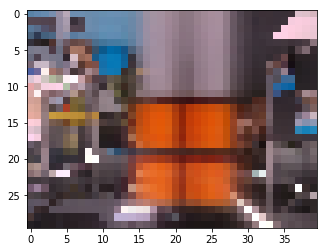

In [15]:
#model_obj.get_decoder(decoder_output_list = [decoder[0][-1]])
a = model_obj.get_decoder().predict(np.asarray([[-0.75, -0.4]]))
a = model_obj.get_decoder().predict(np.asarray([[-1., 1.0]]))
#print(a[0].reshape((60,80,3)))
#image = model_obj.get_decoder(decoder_output_list = [decoder[0][-1]])
#.predict(np.asarray([0., 0.]))
plt.imshow(a[1].reshape((target_size[0], target_size[1],3)))
plt.show()
